# 프로젝트 : 주식 예측에 도전해 보자
***
## < 목차 >
#### STEP 0 : 들어가기 앞서
#### STEP 1 : 시계열 데이터 준비
#### STEP 2 : 시계열 안정성 분석
#### STEP 3 : 각종 전처리 수행
- 기존의 시계열 데이터를 가공/변형
- ❗번외 : 시계열 분해   

#### STEP 4 : 학습, 테스트 데이터셋 생성
#### STEP 5 : 적정 ARIMA 모수 찾기
- auto_arima 사용   

#### STEP 6 : ARIMA 모델 훈련과 테스트
#### STEP 7 : 다른 주식 종목 예측해 보기 (시계열 분해 사용)
###### 1. 애플 (APPL)
###### 2. 테슬라 (TSLA)
###### 3. 에르메스 (RMS)
###### 4. Daily Climate time series data
#### 🤔회고🤔
#### Reference

***
# STEP 0 : 들어가기 앞서
### 개념 정리
- 이번 프로젝트 수행에만 노드가 매우 길어져 개념 정리는 따로 진행하였다.
- 관련 자료들은 회고에 링크로 따로 달겠다.

### 프로젝트 진행
- LMS의 11-9번에 따라 그대로 진행하였을 때, 너무도 완벽하게 그리고 쉽게 루브릭을 완벽하게 맞춘 결과물 3개가 나왔다.   
- 이에 뭔가 잘못되었음을(? 사실은 잘못된건 없었다.) 느끼고 개념부터 익히면서 전처리 방식을 바꿔가면서 진행하려고 노력하였다.
- 따라서 STEP 1~6에서는 기존 시계열 데이터 가공/변형하는 방식으로 전처리를 진행하였고, 이후 STEP 7에서의 주가는 시계열 분해(Time series decomposition) 기법을 적용하였다.
- 뿐만 아니라 LMS에서 그래프 분석을 통해 적정 모수 찾는 방법에 대해 자세히 알려주지 않아 적정 모수 찾는데까지 어려움을 느껴 auto_arima를 통해 적정 모수를 찾는 방법을 사용해보았다.
- 프로젝트를 진행하다보니 순서가 매우 비효율적임을 느껴 순서를 재구성하였다.
- 주가 자료들은 전부 비슷한 결과물을 보여 새로운 시계열 데이터를 사용해보고자 했다.   
    => 캐글의 [기후데이터](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)를 다운받아 진행하였다.
- [프로젝트 초안 보러가기](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-11%5DStock_Prediction_front.ipynb)
***
# STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있음
- 종가(Close)만 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 시계열 안정성 분석

- 해당 시계열 데이터가 안정적인지 ADF Test 진행
- 고정시키는 α 값은 학문 분야에 따라서 다른데 사회과학 분야는 보통 0.05, 자연 과학 분야는 0.01이라는 가이드라인을 제시한다고 함
- 삼성 시계열 데이터는 p-value > α 귀무가설 기각이 불가능하므로 안정적인 시계열이라고 판단하기 어렵다.

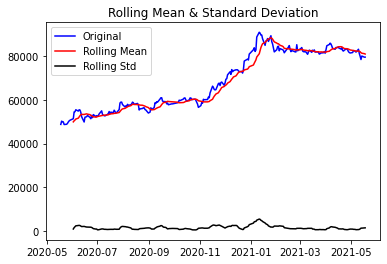

In [30]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts, window=12)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


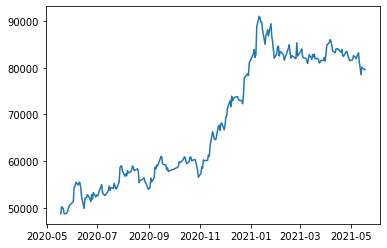

In [3]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts)
plt.plot(ts)

# STEP 3 : 각종 전처리 수행
- 위에서 삼성 시계열 데이터를 안정적이지 않은 시계열로 판단하였으므로 안정적인 시계열로 가공을 위해 2가지 전처리를 진행하겠다.
- 시간 추이에 따라 분산이 커지고 있기 때문에 로그함수 변환을 시도하였지만 생각보다 효과적이지는 않았다. p-value가 0.66 -> 0.59 으로 미미하게 하락했기 때문이다.

In [4]:
# 결측치 처리
ts=ts.interpolate(method='time')
# [[YOUR CODE]]
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


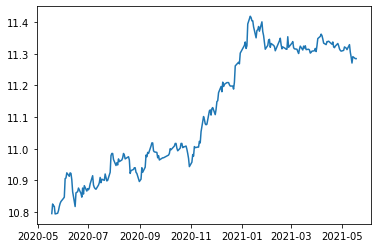

In [6]:
#로그함수 변환 후 시각화
ts_log = np.log(ts)
augmented_dickey_fuller_test(ts_log)
plt.plot(ts_log)

- 시간 추이에 따라 평균이 계속 증가하기 때문에 추세를 상쇄하주도록 하겠다.
- windows size=12로 설정하였기 때문에 앞 11개의 데이터에서 NaN이 발생한다. 따라서 이 결측치들은 추후 에러에 대비해 제거하도록 한다.
- Moving average 제거의 효과는 매우 좋았다. p_value 값이 0.000759 까지로 떨어졌으며, 이제 삼성 시계열 데이터는 안정적인 데이터라고 할 수 있다.

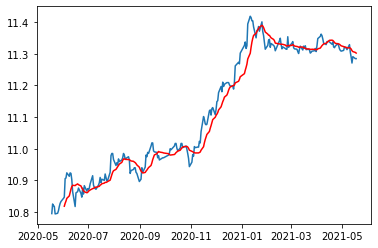

In [7]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [8]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [9]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

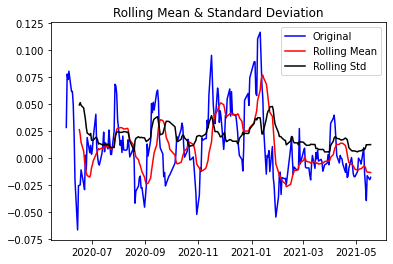

In [12]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log_moving_avg)

In [11]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


## ❗번외❗
- 아래는 시계열 분해를 통해 전처리한 과정이다.
- 확실히 시계열 분해를 통해 전처리 할 때 p-value가 더욱 극적으로 변하는 것을 볼 수 있다.
- 삼성 주가에 대해서는 시계열 데이터 가공/변형하는 방식으로 전처리한 데이터를 사용하여 결과를 도출해낼 예정이다.
- 따라서 아래는 참고용으로 남겨둔다.

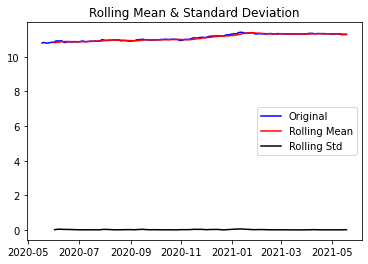

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


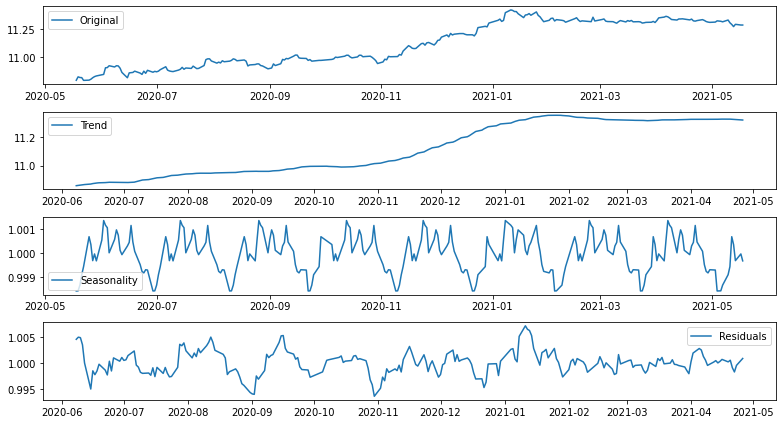

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

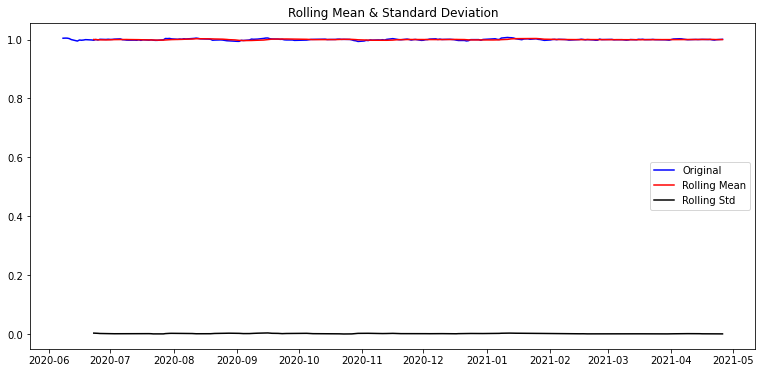

In [8]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

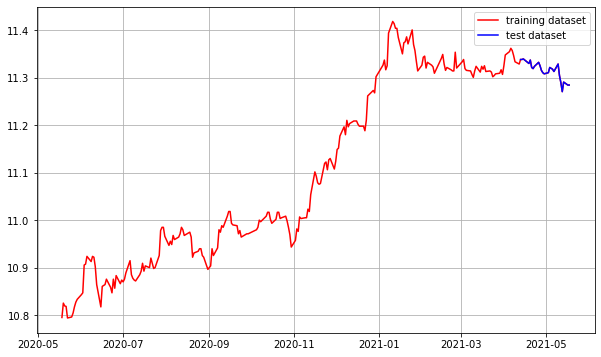

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
-  ARIMA 모델은 3개의 모수를 가진다. : p, q, d
    - p : 자기회귀 모형(AR)의 시차
    - d : 차분 누적(I) 횟수
    - q : 이동평균 모형(MA)의 시차
-  p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻
    => 왜냐? 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문
- ARIMA의 적절한 모수 p, d, q를 선택하는 방법 : ACF(Autocorrelation Function), PACF(Partial Autocorrelation Function)
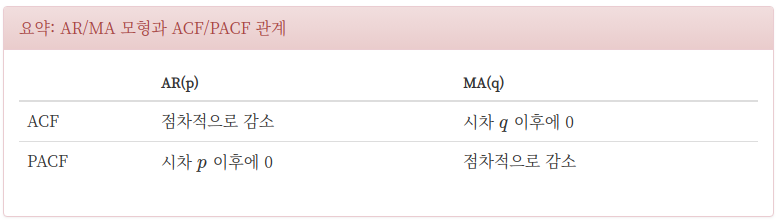
출처 : https://datascienceschool.net
- 그래프를 비교해보았을 때 1차분만으로도 충분하다고 판단하였으나, auto_arima를 통해 구해진 모수를 사용하겠다.
- 추정 차수를 따로 구하는 식도 번외도 작성해보았다.

In [22]:
kpss_diffs = ndiffs(ts_log, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(ts_log, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


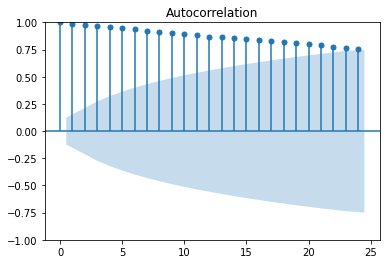

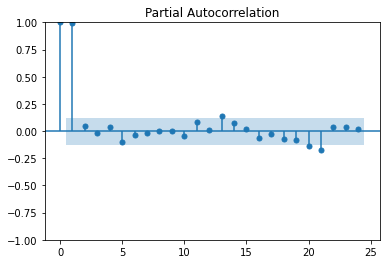

In [15]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


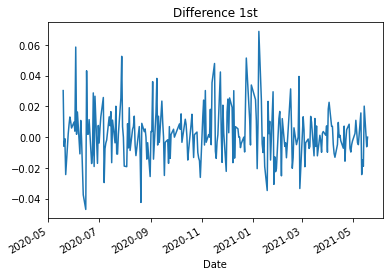

In [37]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

# plt.subplot(131)
augmented_dickey_fuller_test(diff_1)
# plt.subplot(132)
# plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
# plt.subplot(133)
# plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


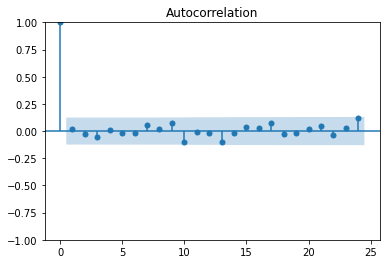

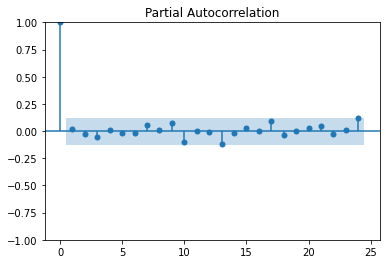

In [39]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## auto_arima 사용
- Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
- 따라서 가장 적정한 모수는 (0,1,0) 이다.
- 2가지 방식

In [20]:
from pmdarima.arima import ndiffs
import pmdarima as pm

In [31]:
model = pm.auto_arima(y = train_data        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1164.726, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.173 seconds


In [25]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1305.690, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1313.151, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1311.207, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1311.208, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1311.916, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1309.213, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.457 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

# STEP 6 : ARIMA 모델 훈련과 테스트

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Thu, 17 Feb 2022   AIC                          -1164.726
Time:                        16:25:48   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


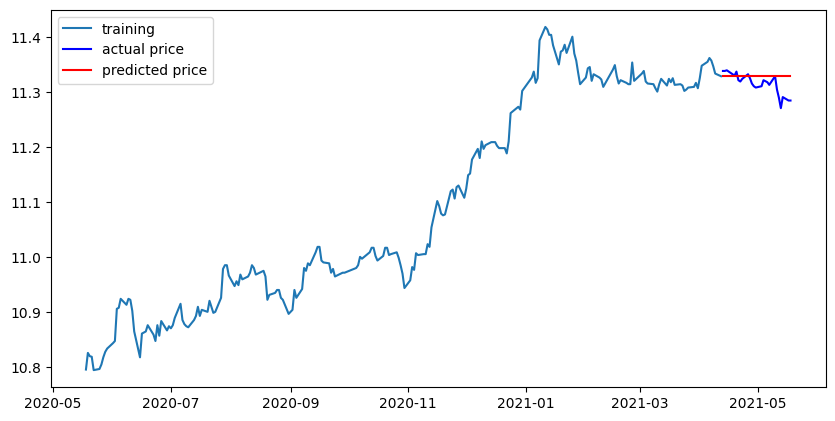

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


# STEP 7 : 다른 주식 종목 예측해 보기
- 아래 주가 예측을 위와 방식이 동일하다.
- 따라서 불필요한 그래프 및 코드 그리고 부연설명은 제외하고 작성하겠다.
***
## 1. APPL
- p-value 0.850872 으로 안정적이지않은 시계열 데이터이다.
- 따라서 전처리 진행 후 학습을 시켜주겠다.

In [40]:
dataset_appl = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_appl, index_col='Date', parse_dates=True)
ts_appl = df['Close']

ts_appl.head()

Date
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
Name: Close, dtype: float64

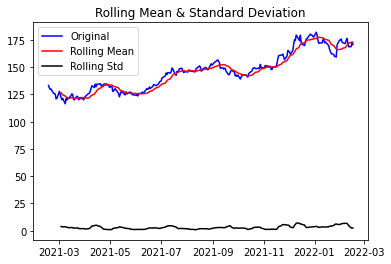

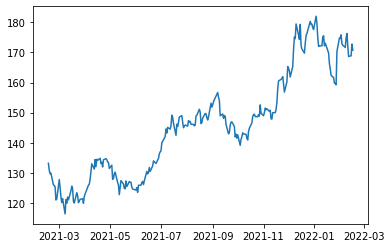

In [45]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_appl, window=12)
plt.plot(ts_appl)

In [43]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_appl)

Results of Dickey-Fuller Test:
Test Statistic                  -0.683913
p-value                          0.850872
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


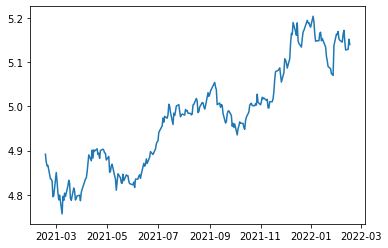

In [44]:
# 로그 변환 후 시각화
ts_appl_log = np.log(ts_appl)
plt.plot(ts_appl_log)

In [46]:
# 결측치 처리
ts_appl=ts_appl.interpolate(method='time')
ts_appl[ts_appl.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

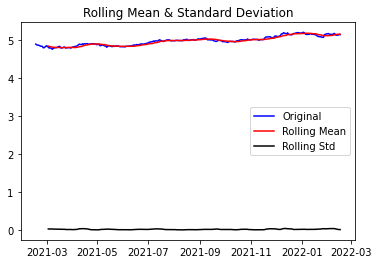

Results of Dickey-Fuller Test:
Test Statistic                  -0.700791
p-value                          0.846545
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


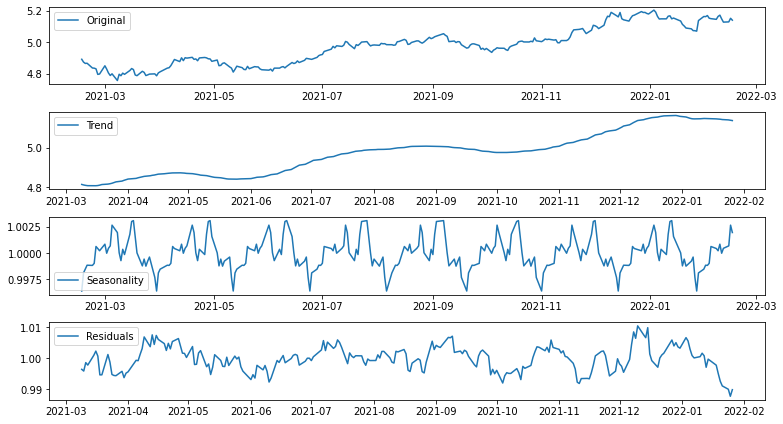

In [47]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_appl_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_appl_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_appl_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_appl_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [48]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.543975
p-value                          0.000164
#Lags Used                       0.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


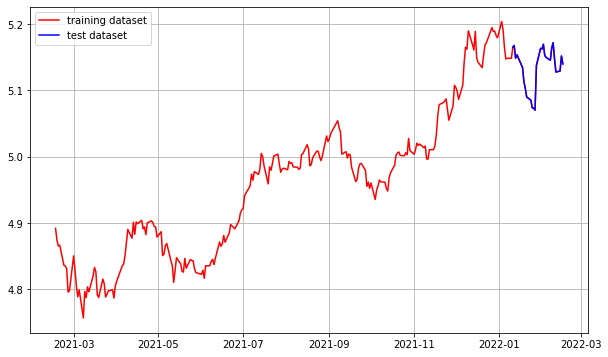

In [49]:
train_data, test_data = ts_appl_log[:int(len(ts_appl_log)*0.9)], ts_appl_log[int(len(ts_appl_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_appl_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


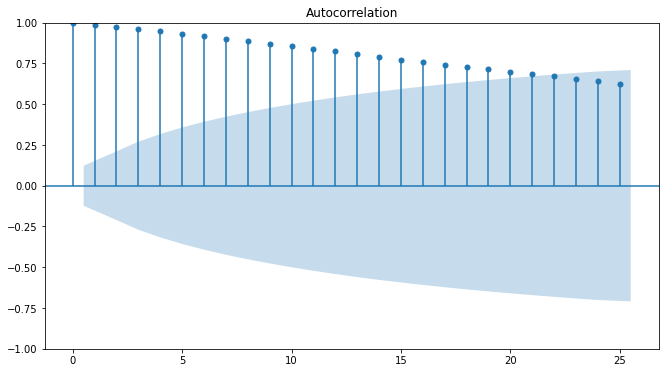

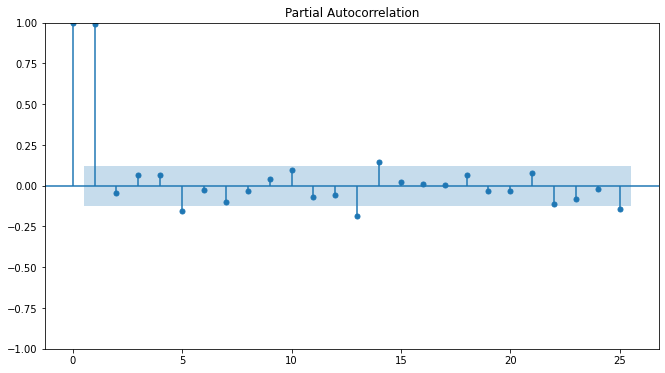

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_appl_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_appl_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.618679e+01
p-value                        4.210790e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


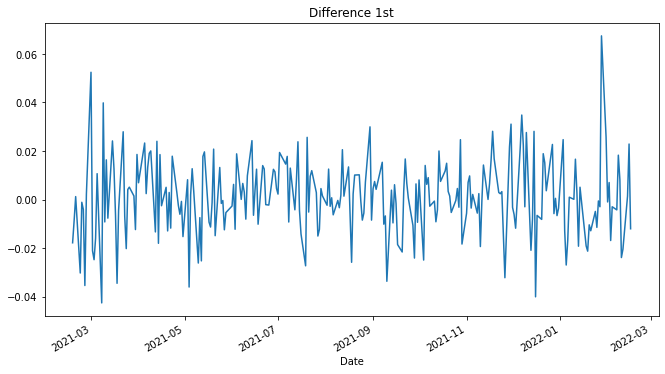

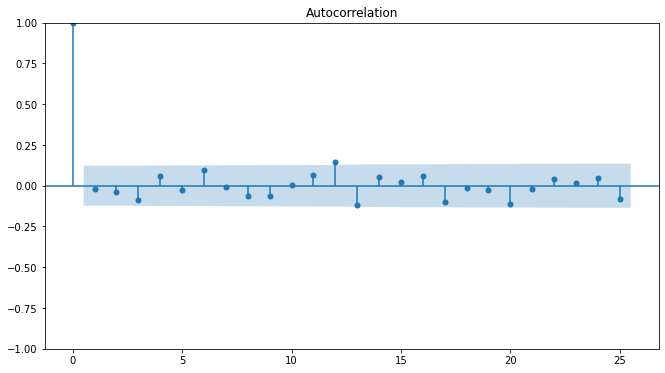

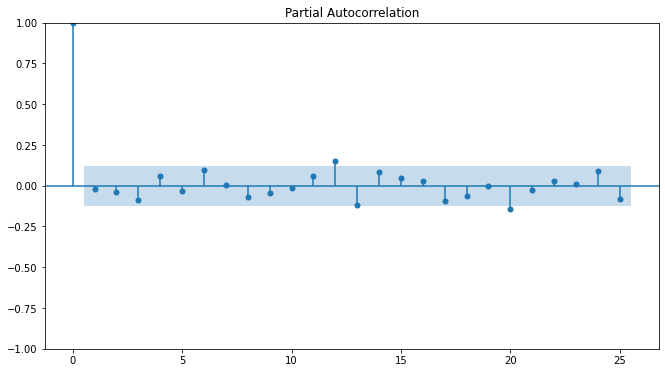

In [52]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_appl_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [53]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(ts_appl_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1255.000, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1258.127, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1257.145, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1257.242, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1258.877, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1255.189, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.616 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### (6)  ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [54]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 630.439
Date:                Thu, 17 Feb 2022   AIC                          -1258.877
Time:                        17:03:59   BIC                          -1255.448
Sample:                             0   HQIC                         -1257.494
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.98e-05     11.699      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.31   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


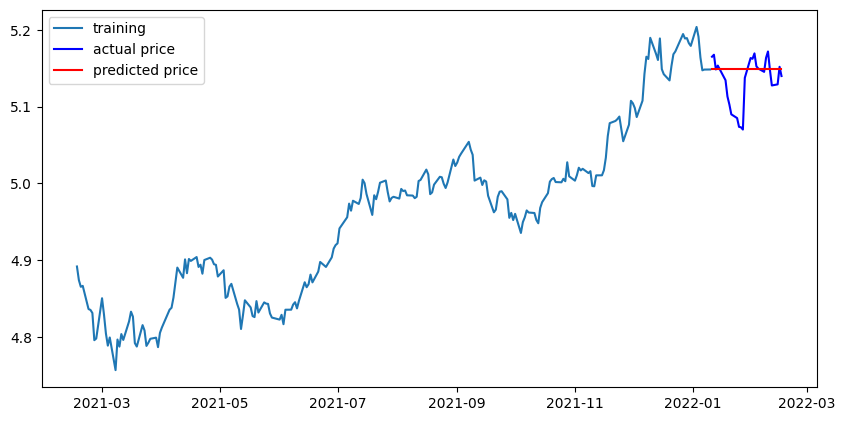

In [55]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34.08806822232614
MAE:  4.194422730769217
RMSE:  5.838498798691847
MAPE: 2.54%


***
## 2. TSLA

In [57]:
dataset_tsla = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_tsla, index_col='Date', parse_dates=True)
ts_tsla = df['Close']

ts_tsla.head()

Date
2021-02-16    796.219971
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
Name: Close, dtype: float64

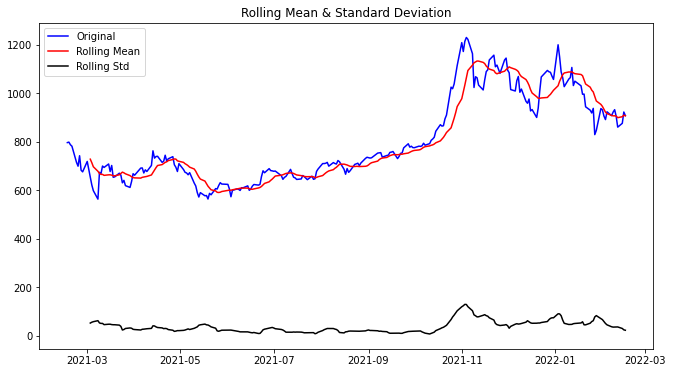

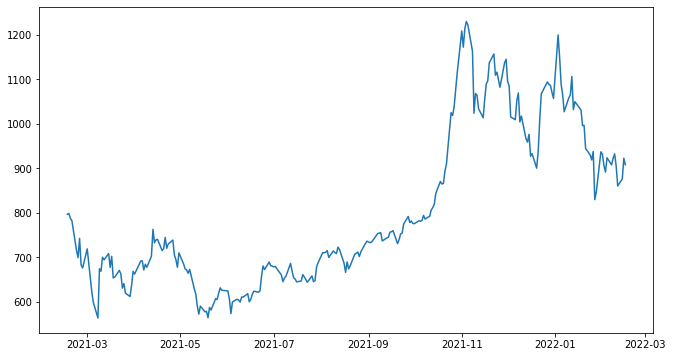

In [60]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_tsla, window=12)
plt.plot(ts_tsla)

In [59]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_tsla)

Results of Dickey-Fuller Test:
Test Statistic                  -1.344392
p-value                          0.608626
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


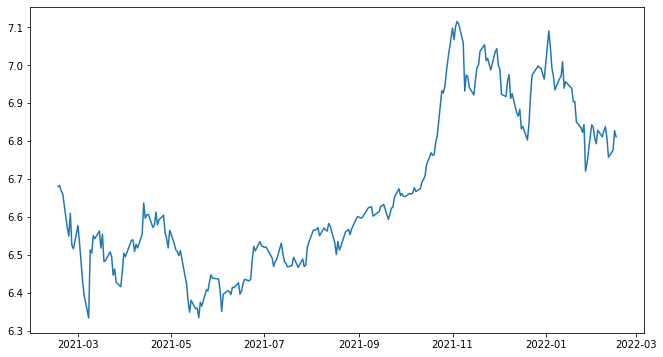

In [61]:
# 로그 변환 후 시각화
ts_tsla_log = np.log(ts_tsla)
plt.plot(ts_tsla_log)

In [62]:
# 결측치 처리
ts_tsla=ts_tsla.interpolate(method='time')
ts_tsla[ts_tsla.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

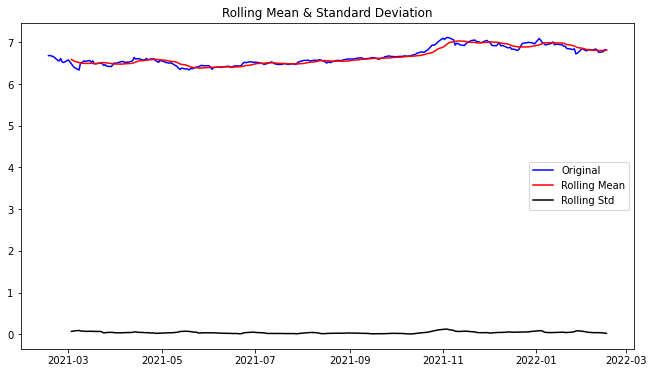

Results of Dickey-Fuller Test:
Test Statistic                  -1.279320
p-value                          0.638579
#Lags Used                       0.000000
Number of Observations Used    254.000000
Critical Value (1%)             -3.456360
Critical Value (5%)             -2.872987
Critical Value (10%)            -2.572870
dtype: float64


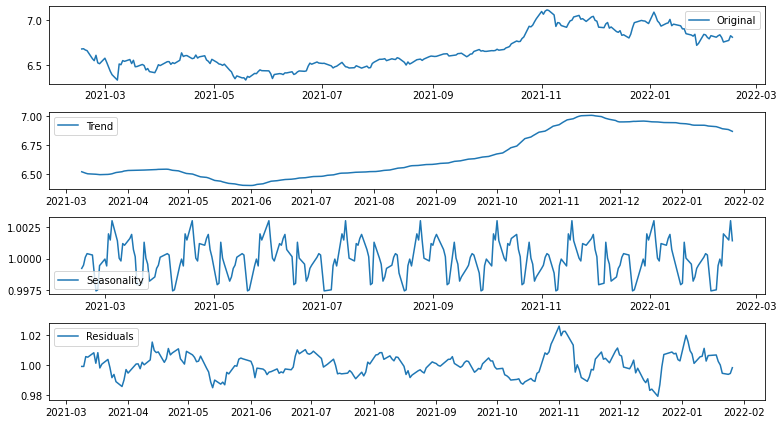

In [63]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_tsla_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_tsla_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_tsla_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_tsla_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [64]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.591796e+00
p-value                        7.084211e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


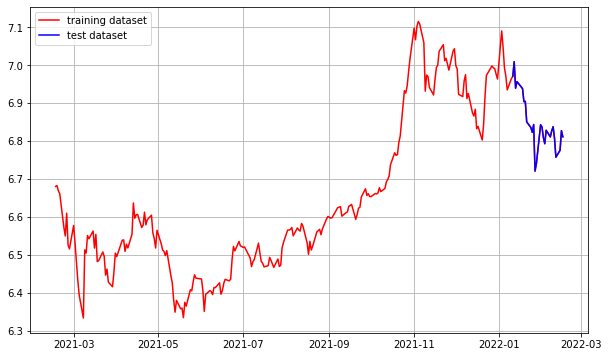

In [65]:
train_data, test_data = ts_tsla_log[:int(len(ts_tsla_log)*0.9)], ts_tsla_log[int(len(ts_tsla_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_tsla_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


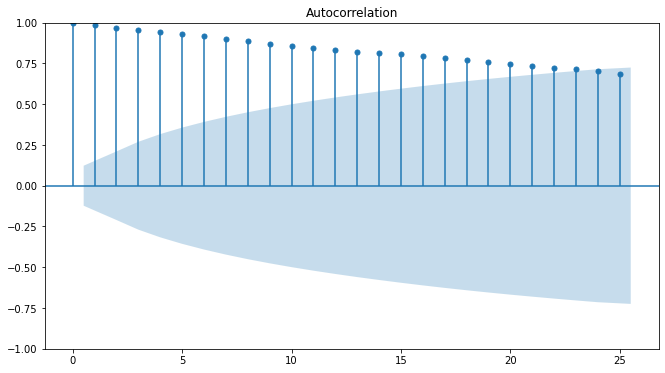

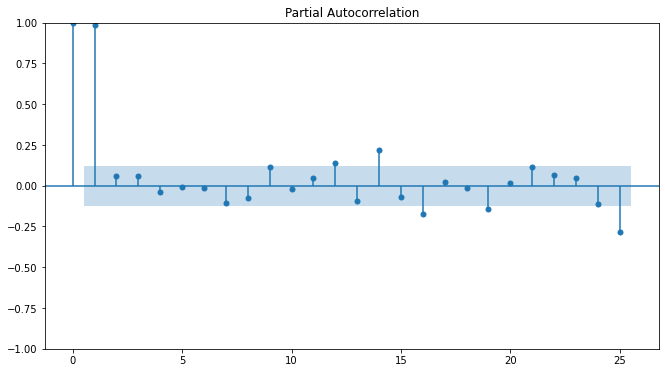

In [66]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_tsla_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_tsla_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.690116e+01
p-value                        1.027452e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.530000e+02
Critical Value (1%)           -3.456464e+00
Critical Value (5%)           -2.873033e+00
Critical Value (10%)          -2.572895e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


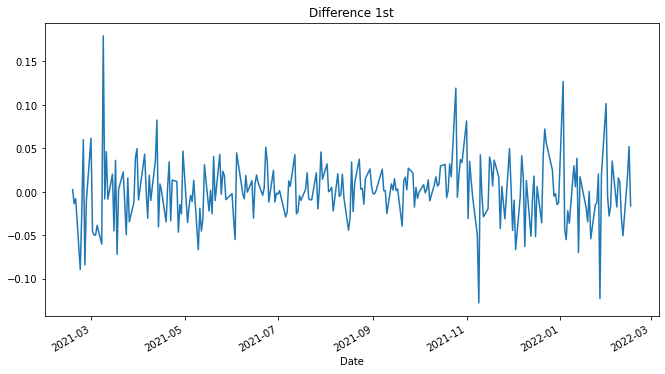

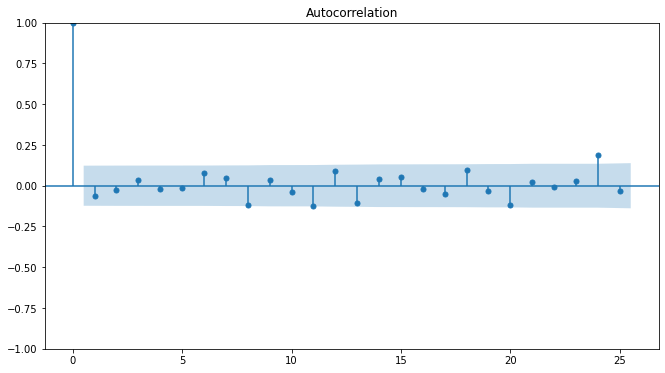

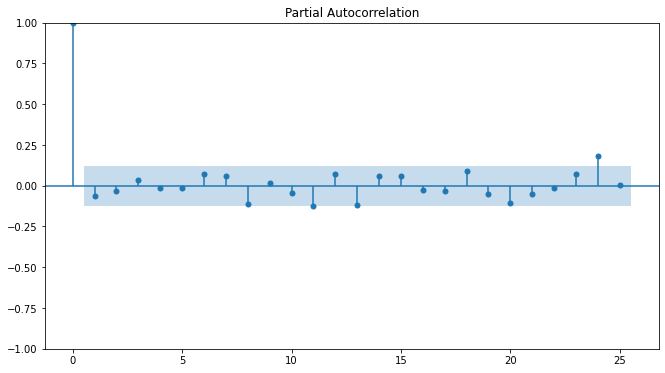

In [67]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_tsla_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [68]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(ts_tsla_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-874.818, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-878.642, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-877.307, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-877.286, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-880.351, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-875.313, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.610 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [69]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 441.176
Date:                Thu, 17 Feb 2022   AIC                           -880.351
Time:                        17:07:59   BIC                           -876.922
Sample:                             0   HQIC                          -878.968
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   6.68e-05     18.277      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               148.34
Prob(Q):                              0.41   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


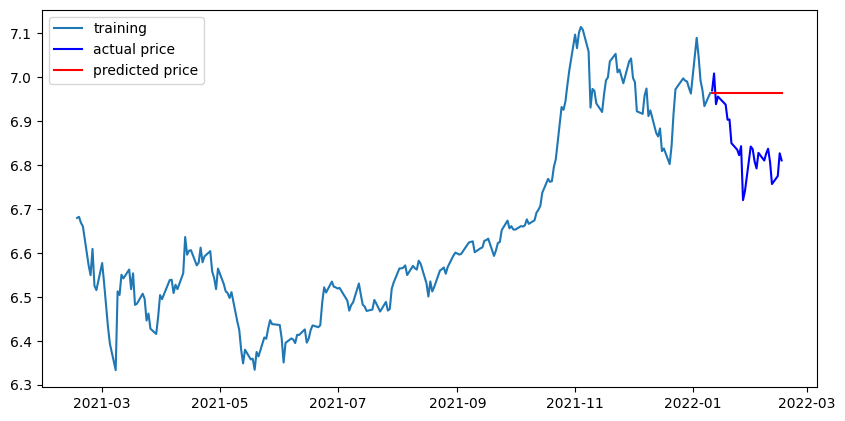

In [70]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17959.10499732519
MAE:  120.02883896153861
RMSE:  134.0115853100962
MAPE: 13.23%


***
## 3. RMS - 기존 방식

In [72]:
dataset_rms = os.getenv('HOME') + '/aiffel/stock_prediction/data/RMS.PA.csv'
df = pd.read_csv(dataset_rms, index_col='Date', parse_dates=True)
ts_rms = df['Close']

ts_rms.head()

Date
2021-02-16    937.000000
2021-02-17    930.400024
2021-02-18    934.599976
2021-02-19    963.599976
2021-02-22    951.000000
Name: Close, dtype: float64

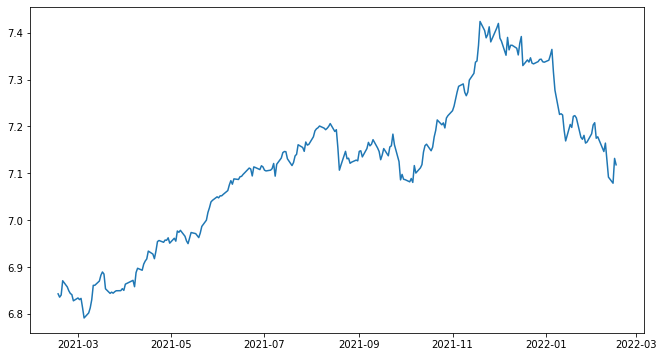

In [73]:
# 로그 변환 후 시각화
ts_rms_log = np.log(ts_rms)
plt.plot(ts_rms_log)

In [74]:
# 결측치 처리
ts_rms=ts_rms.interpolate(method='time')
ts_rms[ts_rms.isna()] 

Series([], Name: Close, dtype: float64)

In [75]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [76]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


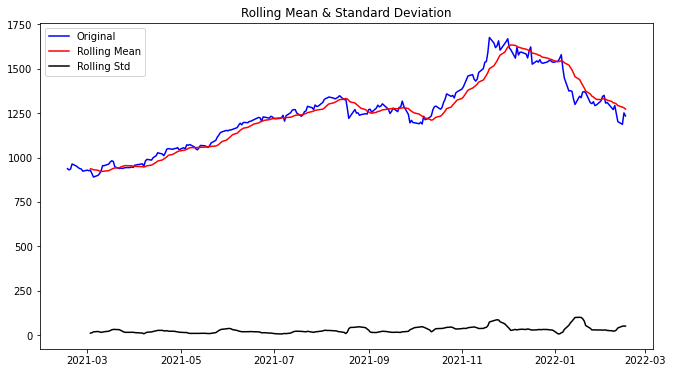

In [77]:
plot_rolling_statistics(ts_rms, window=12)

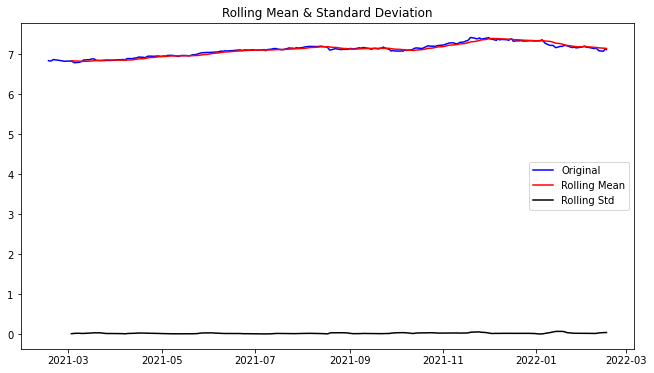

Results of Dickey-Fuller Test:
Test Statistic                  -1.716233
p-value                          0.422769
#Lags Used                       0.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


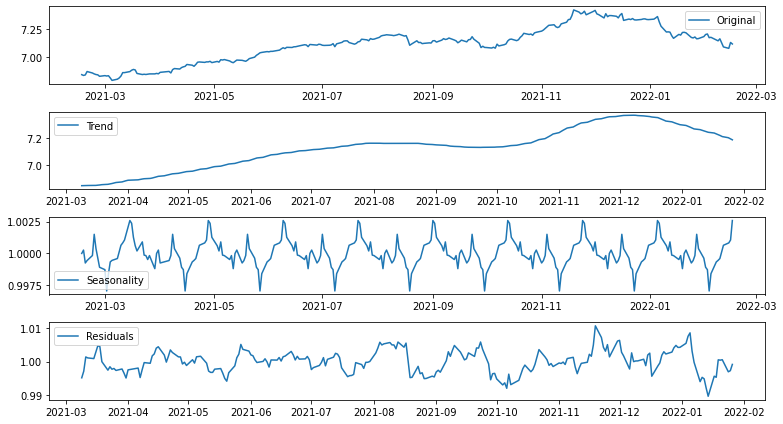

In [78]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_rms_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_rms_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_rms_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_rms_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [79]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.523623
p-value                          0.000002
#Lags Used                       6.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


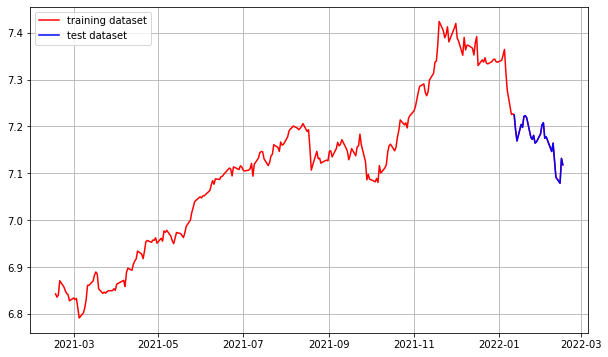

In [80]:
train_data, test_data = ts_rms_log[:int(len(ts_rms_log)*0.9)], ts_rms_log[int(len(ts_rms_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_rms_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


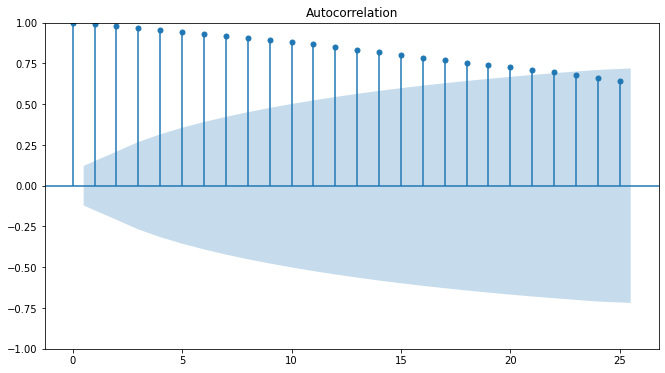

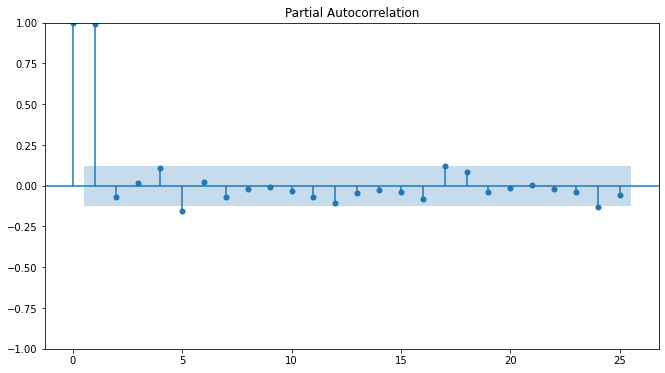

In [81]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_rms_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_rms_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.524104e+01
p-value                        5.162325e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


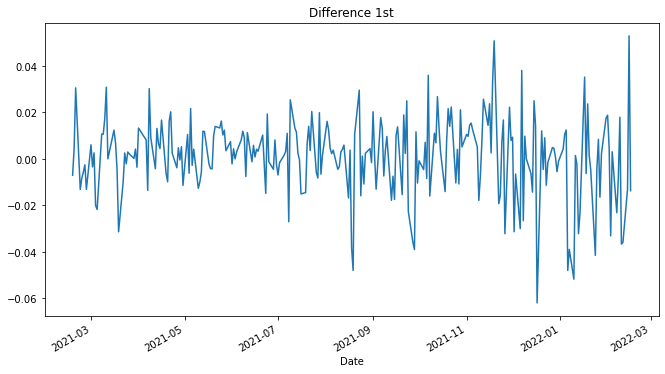

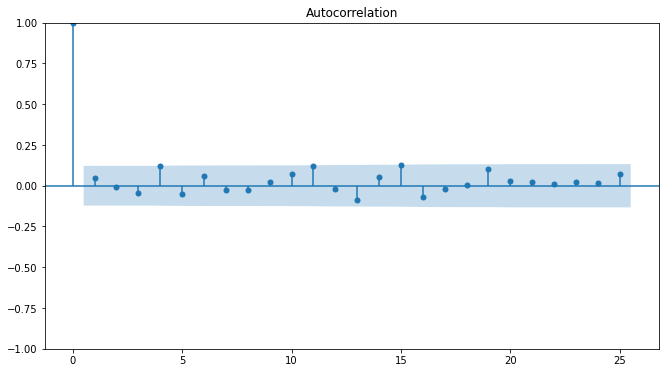

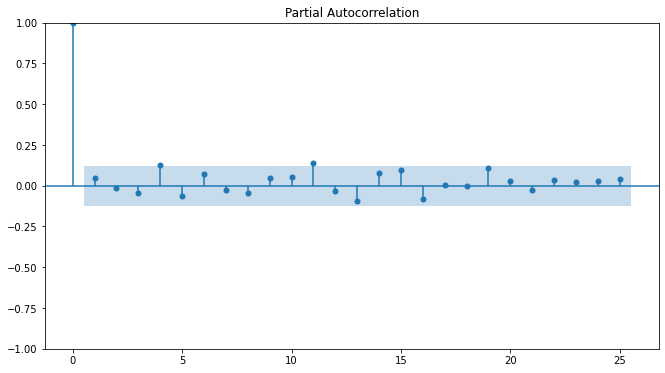

In [82]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_rms_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

In [83]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  234
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 634.592
Date:                Thu, 17 Feb 2022   AIC                          -1267.185
Time:                        17:09:34   BIC                          -1263.734
Sample:                             0   HQIC                         -1265.793
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   1.73e-05     14.598      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                60.83
Prob(Q):                              0.37   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


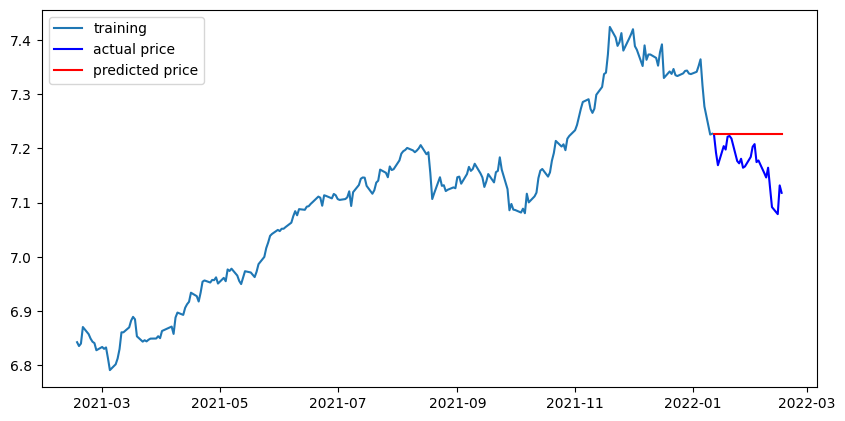

In [84]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7648.509615384615
MAE:  72.63461538461536
RMSE:  87.45575804590922
MAPE: 5.72%


***
## 4. Daily Climate time series data

In [195]:
import matplotlib.pyplot as plt

dataset_climate = os.getenv('HOME') + '/aiffel/stock_prediction/data/DailyDelhiClimateTrain.csv'
df = pd.read_csv(dataset_climate) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


- 위의 DataFrame에서 meantemp 컬럼을 index로 삼아 시계열을 생성

In [196]:
df = pd.read_csv(dataset_climate, index_col='date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


- 시간 컬럼이 index가 되었지만 아직도 type은 DataFrame으로 나옴
- 이를 시계열 데이터로 변경
- meantemp 만을 사용하겠다.

In [197]:
ts = df['meantemp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64

In [198]:
ts[ts.isna()]

Series([], Name: meantemp, dtype: float64)

- 시계열 안정성 분석 결과 해당 데이터는 안정적인 데이터가 아니다.
- 따라서 데이터 전처리를 진행해주겠다.

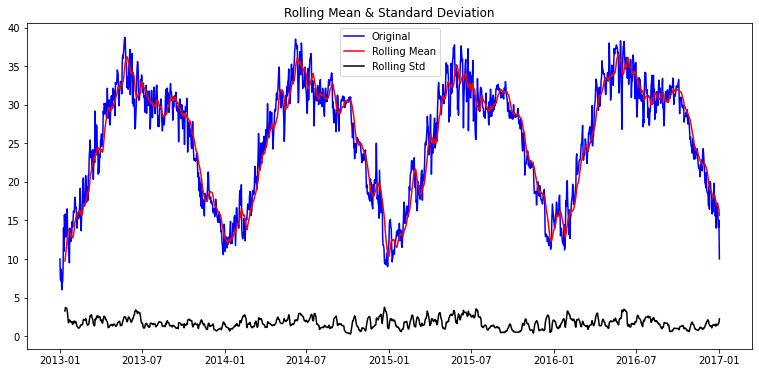

In [199]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts, window=12)

Results of Dickey-Fuller Test:
Test Statistic                   -2.021069
p-value                           0.277412
#Lags Used                       10.000000
Number of Observations Used    1451.000000
Critical Value (1%)              -3.434865
Critical Value (5%)              -2.863534
Critical Value (10%)             -2.567832
dtype: float64


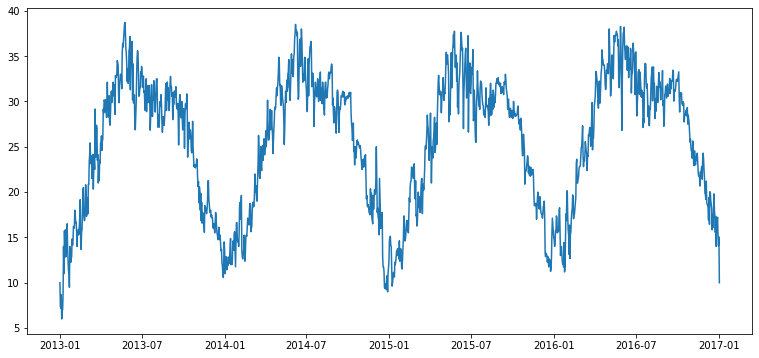

In [200]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts)
plt.plot(ts)

Results of Dickey-Fuller Test:
Test Statistic                   -3.586512
p-value                           0.006024
#Lags Used                        5.000000
Number of Observations Used    1456.000000
Critical Value (1%)              -3.434849
Critical Value (5%)              -2.863527
Critical Value (10%)             -2.567828
dtype: float64


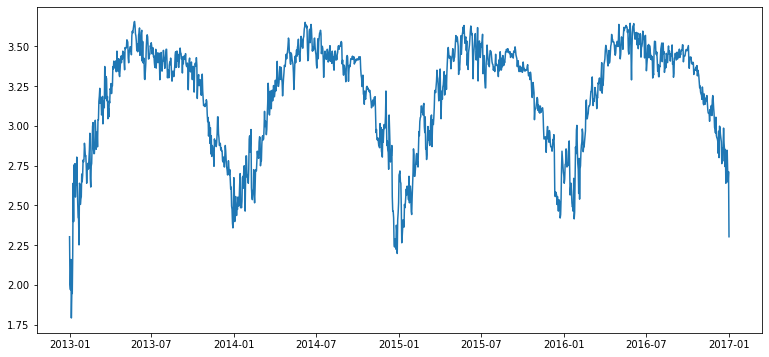

In [201]:
ts_log = np.log(ts)
augmented_dickey_fuller_test(ts_log)
plt.plot(ts_log)

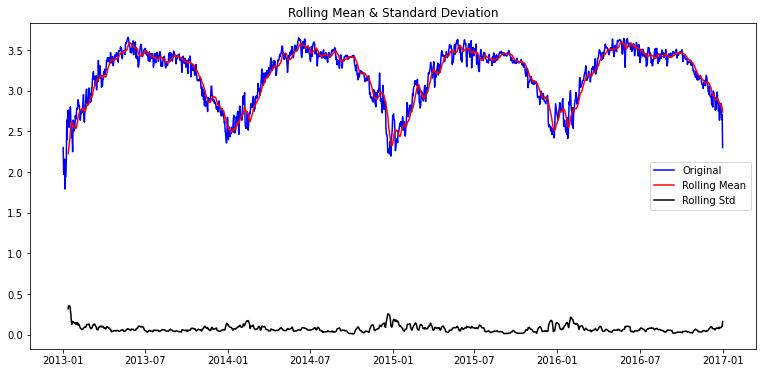

Results of Dickey-Fuller Test:
Test Statistic                   -3.586512
p-value                           0.006024
#Lags Used                        5.000000
Number of Observations Used    1456.000000
Critical Value (1%)              -3.434849
Critical Value (5%)              -2.863527
Critical Value (10%)             -2.567828
dtype: float64


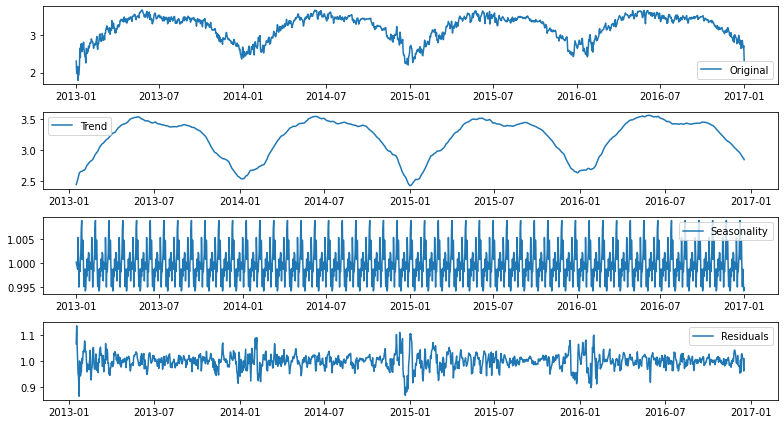

In [202]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

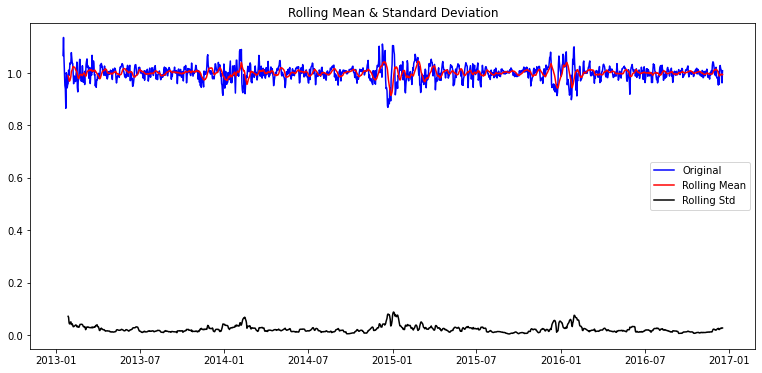

In [203]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [204]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.255772e+01
p-value                        2.136106e-23
#Lags Used                     2.400000e+01
Number of Observations Used    1.407000e+03
Critical Value (1%)           -3.435006e+00
Critical Value (5%)           -2.863596e+00
Critical Value (10%)          -2.567865e+00
dtype: float64


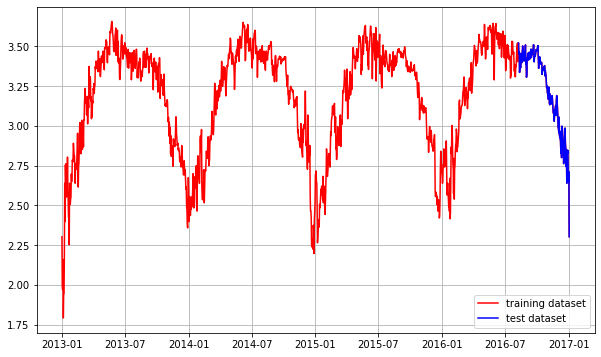

In [205]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [206]:
kpss_diffs = ndiffs(ts_log, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(ts_log, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [165]:
model = pm.auto_arima (train_data, d = 1, seasonal = False, trace = True)
model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3104.430, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3034.400, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3064.727, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3071.952, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3036.212, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3101.308, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3101.342, Time=1.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3102.791, Time=2.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3102.705, Time=3.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3103.039, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3100.767, Time=3.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3100.820, Time=1.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3100.877, Time=4.40 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3105.610, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [222]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(10, 0, 10)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1315
Model:               ARIMA(10, 0, 10)   Log Likelihood                1573.526
Date:                Thu, 17 Feb 2022   AIC                          -3103.052
Time:                        18:26:49   BIC                          -2989.057
Sample:                    01-01-2013   HQIC                         -3060.306
                         - 08-07-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1543      0.072     43.714      0.000       3.013       3.296
ar.L1          0.6950      0.425      1.636      0.102      -0.137       1.528
ar.L2          0.5890      0.577      1.021      0.3

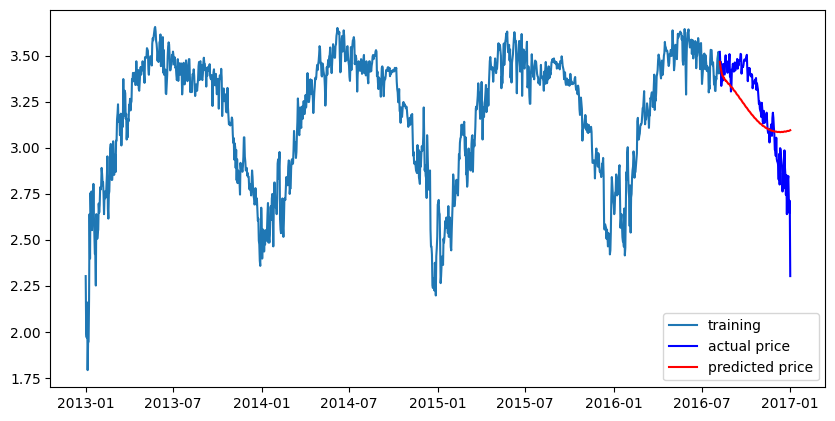

In [223]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [224]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18.15550295761476
MAE:  3.607879024397121
RMSE:  4.260927476220965
MAPE: 14.98%


# 🤔회고🤔

### <루브릭 평가 지표>
|   평가문항    |상세기준|
|---|---|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

***
### <이번 프로젝트에서 어려웠던 점>
- 프로젝트 자체가 어렵기보다는 프로젝트를 위한 이론들이 매우 어려웠다.
- base code를 사용하였을 때 모두 MAPE가 15% 이하로 나왔고,이는 현재 장세를 고려하였을 때, 거의 전 종목이 전반적으로 작년 중~말까지 오르다가 작년 12월부터 올 초까지 휘청거리는 형태를 가지고 있기 때문에 추가 예측 결과가 다 비슷하게 보이는 듯 하다.

***
### <프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>
1. 시계열 데이터
- 시계열 데이터의 종류
    - POS (Point of sales) 구매 자료 (불규칙적인 시차)
    - 일일 코스피 주식가격
    - 월별/분기별/연도별 특정 사건의 수치 (규칙적인 시차)
- 자료 예시
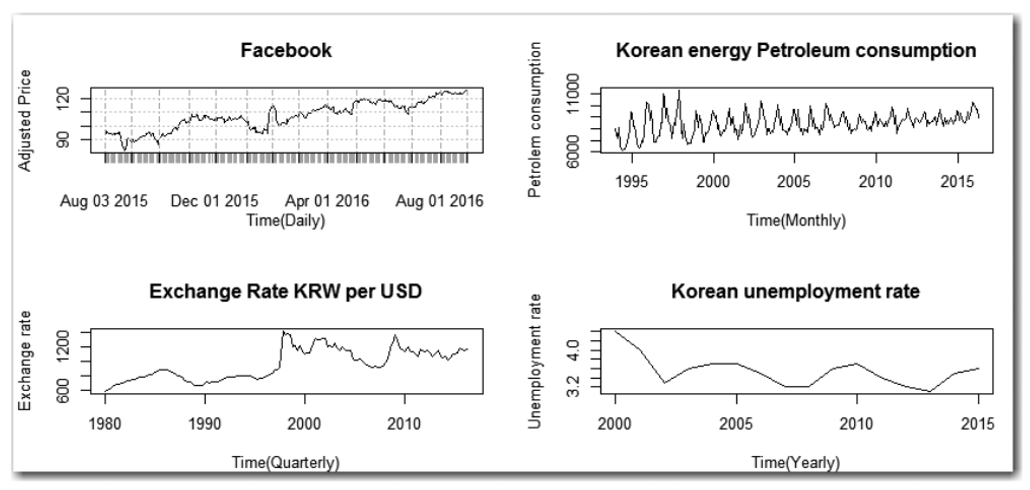
- 주의사항 : y축을 확인하여 노이즈 값에 영향을 많이 받는가를 확인
2. [ADF Test](https://github.com/LAGABI44/Deep_learning_Models/blob/main/ADF%20Test.md)
3. auto_arima
- ARIMA 모델에 대한 최적의 모수를 자동으로 검색해줌
- 정상성 문제로 인해 auto-ARIMA는 수렴할 적절한 모델을 찾지 못할 수 있음
    => 이때는 오류가 뜸
- 주요 옵션
    - y: array 형태의 시계열 자료
    - d (기본값 = none): 차분의 차수, 이를 지정하지 않으면 실행 기간이 매우 길어질 수 있음
    - start_p (기본값 = 2), max_p (기본값 = 5): AR(p)를 찾을 범위 (start_p에서 max_p까지 찾는다!)
    - start_q (기본값 = 2), max_q (기본값 = 5): AR(q)를 찾을 범위 (start_q에서 max_q까지 찾는다!)
    - m (기본값 = 1): 계절적 차분이 필요할 때 쓸 수 있는 모수로 m=4이면 분기별, m=12면 월별, m=1이면 계절적 특징을 띠지 않는 데이터를 의미한다. m=1이면 자동적으로 seasonal 에 대한 옵션은 False로 지정된다.
    - seasonal (기본값 = True): 계절성 ARIMA 모형을 적합할지의 여부
    - stepwise (기본값 = True): 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부, False면 모든 모수 조합으로 모형을 적합한다.
    - trace (기본값 = False): stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용한다.
***
### <루브릭 평가 지표를 맞추기 위해 시도한 것들>
1. 추가 주가 예측 모두 base code를 사용하였다.   
    base code를 사용하였을 때 모두 MAPE가 10% 이하로 나왔고, 생각보다 빠르게 마무리...
2. 따라서 LMS를 다시 처음부터 훑으면서 전처리 과정에 변화를 주었다.
3. 적정 모수 찾는 방법에서도 보다 정확한 적정 모수를 위해 auto_arima를 사용해보았다.
4. 번외로 한 Daily Climate time series data 에서 처음 MAPE는 30%가 넘게 나왔다.
    => 이때 window와 모수들을 만져가며 수치를 변경하였다.
    => 번외를 진행하면서 d와 모수에 자동적으로 구하는 방식이 어쩌면 의미없을 수도 있겠다는 생각이 들었다.
***
### <만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>
없음

***
### <자기 다짐>
- 상당히 흥미로운 프로젝트였다. 물론 흥미만큼 따라가기는 매우 어려웠지만 말이다. 특히나 개념적인 부분들이 매우 생소했는데 한 번 알아두면 유용할 것 같아서 다시 개념 정리하는 시간을 가지는 것이 좋을 것 같다.
- 그래프를 보여 모수 구하는 방식, 그리고 모수 자체에 아직 이해도가 낮아 이에 대해 더욱 공부해야겠다는 생각이 들었다.

# Reference
1. time-series data architecture : https://docs.microsoft.com/ko-kr/azure/architecture/data-guide/scenarios/time-series
2. Time series analysis series : https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/
3. auto_arima : https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima
4. Time series : https://sodayeong.tistory.com/6